# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
##### by Markus Müller

## Content
- [Introduction](#intro)
- [Part 0: Get to know the data](#part0)
- [Part 1: Customer Segmentation Report](#part1)
- [Part 2: Supervised Learning Model](#part2)
- [Part 3: Kaggle Competition](#part3)


<a id='intro'></a>
### Introduction



In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score


import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

<a id='part0'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [2]:
# I downloaded tha data so I can work locally (which is faster for me)
# since the data is confidencial I will delete it after the project assessment
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [3]:
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


#### Checking for duplicates

In [10]:
azdias.duplicated().sum()

0

There are no duplicates in the datasets 

#### Checking for missing values

Form the visual assessment is is clear that the datasets contain missing values (NaNs), but there are also other encodings for missing or unknown data like -1. A quick check in the provided Excel sheets with the explanation of the attributes and the possible value each can be, -1 is, as assumed, also a code for unknown, as well as 9 and 0 in some cases.
A possible solution is to look at the Excel and hard-code the unknown values, but we can use pandas for this.

When checking for missing values I noticed that the length of the Attributes in the Excel don't match with the columns in the azdias DataFrame.

In [5]:
# load the Excel file
attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=1)
attributes_values.drop(columns='Unnamed: 0', inplace=True)

In [6]:
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [7]:
# check if count of Attributes fit the columns of the DataFrame
attributes = list(attributes_values['Attribute'].dropna())

In [8]:
len(attributes)

314

In [9]:
len(azdias.columns)

366

The azdias DataFrame has 366 columns, so there as to be some Attributes that are not in the Excel file. Since I don't have any description of those 53 entries, I am going to drop them 

In [10]:
# https://stackoverflow.com/questions/52976664/python-differences-between-two-lists
def difference(list1, list2):
    return len(list(set(list1) - set(list2)))

In [11]:
difference(attributes, azdias)

42

In [12]:
difference(azdias, attributes)

94

In [13]:
def intersection(list1, list2):
    return len(list(set(list1) & set(list2)))

In [14]:
intersection(azdias, attributes)

272

In [15]:
intersected_cols = list(set(azdias) & set(attributes))

So there are 42 attributes missing in the azdias dataset that are in the Excel file and 94 attributes that are in the datatset but not in th Excel file. This leaves us with an intersection of 272 attributs for which we have a description and the data.

In [16]:
# https://stackoverflow.com/questions/56891518/how-to-drop-columns-if-they-are-not-presented-in-specific-list-in-pandas
azdias = azdias[azdias.columns.intersection(intersected_cols)]

In [17]:
# now we have only the attributes for which we have a discription
azdias.shape

(891221, 272)

##### create a DataFrame with the values for missing values
problem: 0 and 9 aren't always used for unknown/missing values.

In [18]:
# to get the unkown values: filter the DataFrame for unknown in column Meaning
unknown_vals = attributes_values[attributes_values['Meaning'].isin(['unknown'])]
unknown_vals.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [19]:
unknown_vals['Value_split'] = unknown_vals['Value'].astype(str).str.split(',')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
# check if we can access the values to use in a for loop
unknown_vals.loc[unknown_vals['Attribute'] == 'AGER_TYP', 'Value_split'].iloc[0]

['-1']

In [21]:
azdias['AGER_TYP']

0        -1
1        -1
2        -1
3         2
4        -1
         ..
891216   -1
891217   -1
891218   -1
891219   -1
891220   -1
Name: AGER_TYP, Length: 891221, dtype: int64

In [22]:
# check mapping to find unkonwn/missing values
azdias.loc[:, 'AGER_TYP'].isin(['-1']).head()

0     True
1     True
2     True
3    False
4     True
Name: AGER_TYP, dtype: bool

In [23]:
# find value and replace with np.NaN
azdias.loc[0, 'AGER_TYP'] = np.NaN

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
# loop through the attributes from the unknown DataFrame
for row in unknown_vals['Attribute']:
    print(row)
    if row in azdias.columns:
        find_na = unknown_vals.loc[unknown_vals['Attribute'] == row, 'Value_split'].iloc[0]
        find_idx = azdias.loc[:, row].isin(find_na)
        azdias.loc[find_idx, row] = np.NaN
    else:
        continue

AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
nan
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_HERSTTEMP
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXHERST
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MODTEMP
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_SEG4
KBA05_SEG5
KBA05

In [25]:
# Now the -1 in the AGER_TYP column is now NaN
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,0.0,11.0,0.0,2.0,0.0,6.0,8A,8,5.0,...,1.0,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4,3.0,...,4.0,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2,2.0,...,4.0,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6,5.0,...,7.0,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0


##### check null values

In [26]:
# devide the total null values with the shape of the whole DataFrame to get the proportions
count_na_col = azdias.shape[0] - azdias.count(axis=0)

Text(0.5, 0, 'Missing values')

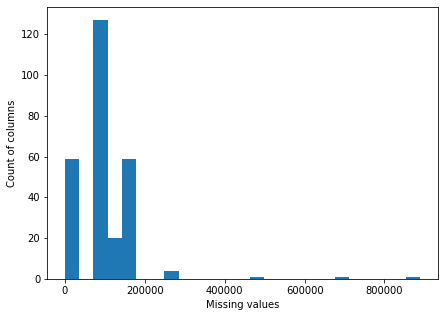

In [27]:
fig = plt.figure(figsize=(7,5))

ax = plt.subplot()
ax.hist(count_na_col, bins=25)
ax.set_ylabel('Count of columns')
ax.set_xlabel('Missing values')
# plt.savefig('hist_col_na.png', dpi=200, bbox_inches='tight')

Based on the histogram I am going to remove columns with more than 200000 missing values a column.

In [28]:
count_na_col[count_na_col > 200000].index

Index(['AGER_TYP', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_BAUMAX',
       'TITEL_KZ'],
      dtype='object')

In [29]:
# drop cloumns
azdias.drop(columns=count_na_col[count_na_col > 200000].index, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
azdias.shape

(891221, 265)

##### check for missing values on the row level

In [31]:
count_na_row = azdias.shape[1] - azdias.count(axis=1)

Text(0.5, 0, 'Missing values')

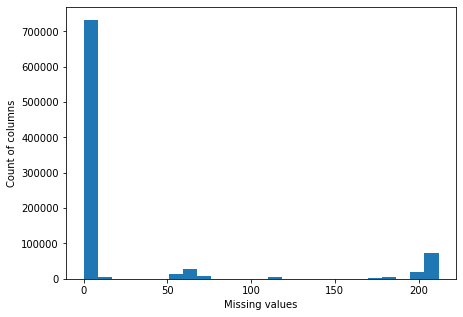

In [32]:
fig = plt.figure(figsize=(7,5))

ax = plt.subplot()
ax.hist(count_na_row, bins=25)
ax.set_ylabel('Count of columns')
ax.set_xlabel('Missing values')
# plt.savefig('hist_row_na.png', dpi=200, bbox_inches='tight');

Based on the histogram, I am going to drop rows that have more than 50 missing values 

In [33]:
count_na_row[count_na_row > 50].index

Int64Index([     0,     11,     12,     13,     14,     15,     17,     20,
                23,     24,
            ...
            891164, 891169, 891170, 891171, 891172, 891173, 891175, 891185,
            891187, 891203],
           dtype='int64', length=153933)

In [34]:
azdias.drop(index=count_na_row[count_na_row > 50].index, inplace=True)

In [35]:
azdias.shape

(737288, 265)

### Preprocess Features
- check if features are numeric, to use them for the ML algorithms

In [36]:
# only five features aren't numerical 
azdias.select_dtypes('O').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Data columns (total 3 columns):
CAMEO_DEU_2015     734232 non-null object
CAMEO_DEUG_2015    734232 non-null object
OST_WEST_KZ        737288 non-null object
dtypes: object(3)
memory usage: 22.5+ MB


In [37]:
azdias.select_dtypes('O').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ
1,8A,8,W
2,4C,4,W
3,2A,2,W
4,6B,6,W
5,8C,8,W


In [38]:
# CAMEO_DEU has a lot of different categories so I will drop it, beause it would add a more compelxity to the model
azdias.CAMEO_DEU_2015.value_counts()

6B    54006
8A    50776
4C    43988
2D    32906
7A    32630
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64

In [39]:
# The column seems to contain different dtypes: ints and floats 
azdias.CAMEO_DEUG_2015.value_counts()

8      74754
6      58203
9      57473
4      55290
8.0    54106
2      44419
3      44192
6.0    42489
9.0    41978
7      41861
4.0    40292
2.0    32192
3.0    32129
7.0    30623
5      28976
5.0    20737
1      19840
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64

In [40]:
azdias.OST_WEST_KZ.value_counts()

W    582290
O    154998
Name: OST_WEST_KZ, dtype: int64

Result
- drop CAMEO_DEU_2015, to to many categories
- CAMEO_DEUG_2016: remove XX replace with np.NaN
- OST_WEST_KZ: get dummies

##### drop CAMEO_DEU_2015, due to to many categories

In [41]:
azdias.drop(columns='CAMEO_DEU_2015', inplace=True)

##### CAMEO_DEUG_2016: remove XX replace with np.NaN

In [42]:
azdias.CAMEO_DEUG_2015.replace('X', np.NaN, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [43]:
azdias['CAMEO_DEUG_2015'] = pd.to_numeric(azdias.CAMEO_DEUG_2015)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
azdias['CAMEO_DEUG_2015'].value_counts()

8.0    128860
6.0    100692
9.0     99451
4.0     95582
2.0     76611
3.0     76321
7.0     72484
5.0     49713
1.0     34234
Name: CAMEO_DEUG_2015, dtype: int64

##### OST_WEST_KZ: get dummies

In [45]:
azdias['OST_WEST_KZ'] = pd.get_dummies(azdias.OST_WEST_KZ, drop_first=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
azdias['OST_WEST_KZ'].value_counts()

1    582290
0    154998
Name: OST_WEST_KZ, dtype: int64

The dataset also contains features that are numerical but repersent categorical/ordinal or nominal data. I looked at the provided Excel file and checked for such features.

In [47]:
# column used to check if Attribute is in the DataFrame
azdias.LP_LEBENSPHASE_FEIN

1         21.0
2          3.0
3          0.0
4         32.0
5          8.0
          ... 
891216     2.0
891217     2.0
891218     0.0
891219    29.0
891220     6.0
Name: LP_LEBENSPHASE_FEIN, Length: 737288, dtype: float64

In [48]:
# WOHNlage has a 0 for no score calculated to make it ordinal and use it later I will replace 0 with np.NaN
azdias.WOHNLAGE.value_counts()

3.0    235402
7.0    161356
4.0    127406
2.0     94544
5.0     67924
1.0     41440
8.0      9199
0.0        17
Name: WOHNLAGE, dtype: int64

In [49]:
azdias.WOHNLAGE.replace(0.0, np.NaN, inplace=True)

In [50]:
dummy_features = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST','KBA05_MODTEMP', 
                  'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

drop_cols = ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN']

In [51]:
# drop columns
azdias.drop(columns=drop_cols, inplace=True)

In [52]:
# get unique columns to use for clean function
azdias_columns = azdias.columns

In [53]:
# make dummies
for col in dummy_features:
    dummies = pd.get_dummies(azdias[col], prefix=col)
    azdias = pd.concat([azdias, dummies], axis = 1)

In [54]:
azdias.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,0.0,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,17.0,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,13.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,20.0,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,5,...,0,1,0,0,0,0,1,0,0,1
5,10.0,5.0,0.0,1.0,0.0,6.0,8.0,2.0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [55]:
# drope base columns
azdias.drop(columns=dummy_features, inplace=True)

In [56]:
# azdias.to_csv('azdias_clean.csv', index=False)

In [57]:
azdias.shape

(737288, 296)

### Cleaning Function for Customers

In [58]:
# load customers dataset
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [59]:
def clean(df_new, df_clean_columns, unknown_vals, dummy_features):
    '''
    Input
        df_new: customers DataFrame with the origianl data
        df_columns: columns from clean DataFrame 
        unknown_vals: DataFrame with the unknown values for the attributes
        dummy_features: list with the vraibales for dummy transformation
    
    Return
        clean customers DataFrame
    '''
    # assign local variables
    customers = df_new
    azdias = azdias_columns
    
    # make sure the columns are equal in both datasets
    
    # creat list with insected columns
    intersected_cols = list(set(customers) & set(azdias))
    customers = customers[customers.columns.intersection(intersected_cols)]

    print('customers DataFrame has been filtered')
    
    # replace unknown values with np.NaN
    for row in unknown_vals['Attribute']:
        if row in customers.columns:
            find_na = unknown_vals.loc[unknown_vals['Attribute'] == row, 'Value_split'].iloc[0]
            find_idx = customers.loc[:, row].isin(find_na)
            customers.loc[find_idx, row] = np.NaN
        else:
            continue
    
    print('unkown values have been replaced with np.NaN')
    
    # process features
    customers['CAMEO_DEUG_2015'].replace('X', np.NaN, inplace=True)
    customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'])
    
    customers['OST_WEST_KZ'] = pd.get_dummies(customers['OST_WEST_KZ'], drop_first=True)
    
    customers['WOHNLAGE'].replace(0.0, np.NaN, inplace=True)
    
    print('features have been processed')
    
    # create dummies
    for col in dummy_features:
        dummies = pd.get_dummies(customers[col], prefix=col)
        customers = pd.concat([customers, dummies], axis = 1)
        
    customers.drop(columns=dummy_features, inplace=True)
    
    print('finish')
    
    return customers

In [60]:
customers = clean(customers, azdias_columns, unknown_vals, dummy_features)

customers DataFrame has been filtered
unkown values have been replaced with np.NaN
features have been processed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


finish


In [61]:
customers

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,10.0,1.0,0.0,2.0,0.0,3.0,1.0,0,0,10,...,0,1,0,0,0,0,0,1,1,0
1,11.0,NaN,NaN,3.0,0.0,NaN,NaN,0,1,6,...,0,1,0,0,0,0,0,1,1,0
2,6.0,1.0,0.0,1.0,0.0,7.0,5.0,0,0,10,...,0,1,0,0,0,1,0,0,0,1
3,8.0,0.0,NaN,0.0,0.0,7.0,4.0,0,0,10,...,0,1,0,0,1,0,0,0,1,0
4,20.0,7.0,0.0,4.0,0.0,3.0,7.0,1,2,3,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,9.0,1.0,0.0,1.0,0.0,1.0,1.0,0,1,7,...,0,1,0,0,0,1,0,0,0,1
191648,0.0,0.0,NaN,0.0,0.0,6.0,5.0,0,0,10,...,0,1,0,0,0,0,0,1,0,1
191649,15.0,1.0,0.0,3.0,0.0,7.0,4.0,0,0,10,...,0,1,0,0,1,0,0,0,1,0
191650,13.0,4.0,0.0,4.0,0.0,3.0,4.0,1,1,5,...,0,1,0,0,0,0,1,0,1,0


In [62]:
customers.shape[1], azdias.shape[1]

(295, 296)

In [63]:
# azdias has one dummy variable more than customers
set(azdias) - set(customers)

{'GEBAEUDETYP_5.0'}

In [64]:
# we need to drop this dummy variable, otherwise it will lead to problems later on at the scaling process
azdias.drop(columns='GEBAEUDETYP_5.0', inplace=True)

### Imputation and scaling features

In [65]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [66]:
# impute median
azdias_imp = pd.DataFrame(imputer.fit_transform(azdias))
customers_imp = pd.DataFrame(imputer.fit_transform(customers))

In [67]:
# scale features
azdias_sc = pd.DataFrame(scaler.fit_transform(azdias_imp), columns = azdias.columns)
customers_sc = pd.DataFrame(scaler.transform(customers_imp), columns = customers.columns)

In [68]:
azdias_sc.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-1.430675,0.186813,-0.125303,0.224688,-0.06066,0.850057,0.979671,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,-0.658336,-0.601069,1.891938,-0.907560,0.995693
1,0.801403,0.120634,-0.125303,-0.634469,-0.06066,-0.980372,-0.631281,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,-0.658336,1.663701,-0.528559,1.101855,-1.004325
2,0.276209,-0.474979,-0.125303,-1.493626,-0.06066,-0.065157,-1.436757,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,1.101855,-1.004325
3,1.195299,-0.342620,-0.125303,1.943002,-0.06066,-0.980372,0.174195,5.175356,6.173409,-2.351066,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,-0.658336,1.663701,-0.528559,-0.907560,0.995693
4,-0.117688,-0.210262,-0.125303,-0.634469,-0.06066,0.850057,0.979671,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,2.227918,-0.658336,-0.601069,-0.528559,-0.907560,0.995693


In [69]:
customers_sc.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-0.117688,-0.474979,-0.125303,0.224688,-0.06066,-0.522764,-1.839495,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,-0.658336,-0.601069,1.891938,1.101855,-1.004325
1,0.013611,-0.474979,-0.125303,1.083845,-0.06066,0.392450,-0.631281,-0.237853,0.989375,-1.792391,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,-0.658336,-0.601069,1.891938,1.101855,-1.004325
2,-0.642882,-0.474979,-0.125303,-0.634469,-0.06066,1.307664,-0.228543,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,-0.907560,0.995693
3,-0.380285,-0.541158,-0.125303,-1.493626,-0.06066,1.307664,-0.631281,-0.237853,-0.306633,0.442306,...,-0.071433,0.442567,-0.295836,-0.205764,2.227918,-0.658336,-0.601069,-0.528559,1.101855,-1.004325
4,1.195299,-0.077904,-0.125303,1.943002,-0.06066,-0.522764,0.576933,1.566550,2.285383,-3.468414,...,-0.071433,0.442567,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,-0.907560,0.995693


### Are there highly corrleated features?

https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

In [70]:
azdias_corr_matrix = azdias_sc.corr().abs()

In [71]:
azdias_upper = azdias_corr_matrix.where(np.triu(np.ones(azdias_corr_matrix.shape), k=1).astype(np.bool))

In [72]:
azdias_to_drop = [column for column in azdias_upper.columns if any(azdias_upper[column] > 0.95)]

In [73]:
azdias_to_drop

['D19_VERSAND_ONLINE_DATUM',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_STATUS_GROB',
 'ANREDE_KZ_2.0',
 'KBA05_MODTEMP_5.0']

In [74]:
customers_corr_matrix = customers_sc.corr().abs()

In [75]:
customers_upper = customers_corr_matrix.where(np.triu(np.ones(customers_corr_matrix.shape), k=1).astype(np.bool))

In [76]:
customers_to_drop = [column for column in customers_upper.columns if any(customers_upper[column] > 0.95)]

In [77]:
customers_to_drop

['KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_STATUS_GROB',
 'ANREDE_KZ_2.0',
 'KBA05_MODTEMP_5.0']

In [78]:
# drop highly correlated columns
# use customers_to_drop so all columns expect D19_VERSOND_ONLINE_DATUM 
azdias_sc.drop(columns= customers_to_drop, inplace= True)
customers_sc.drop(columns= customers_to_drop, inplace= True)

<a id='part1'></a>
## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [79]:
# code from the Book: Hands on Machine Learning with Scikit Learn
pca = PCA()
pca.fit(azdias_sc)
cumsum = np.cumsum(pca.explained_variance_ratio_)

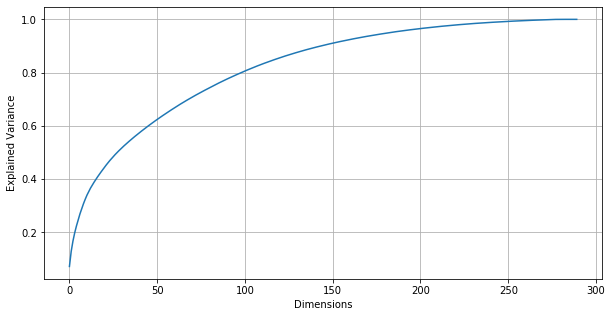

In [80]:
# plot cumsum to get the explained varaiance per dimension added
fig = plt.figure(figsize=(10,5))

ax = plt.subplot()
ax.plot(cumsum)
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Dimensions')
plt.grid()
# plt.savefig('pca.png', dpi=200, bbox_inches='tight');

According to the book 'Hands on Machine Learning', it is important to choose a number of dimensions that add up to a sufficiently large portion of variance, like 95%. So in this case we can reduce the number of dimensions to 150 to get roughly 95% explained variance.

In the next step I will reduce to dimensions for both datasets:

In [81]:
# create a function for fit and transfrom
def pca_fit_transform(n, df):
    '''
    Input
        n: number of components
        df: scaled DataFrame
    
    Return
        pca: model with a fitted pca
        pca_p: pca for population
        
    '''
    pca = PCA(n)
    x_pca = pca.fit_transform(df)
    return pca, x_pca

# create a function for transforming a new DataFrame
def pca_transform(pca, df):
    '''
    Input
        pca: fitted model
        df: new scaled DataFrame
    
    Return
        transformed DataFrame
    '''
    trans_x_pca = pca.transform(df)
    return trans_x_pca

In [82]:
# fit a pca with 150 components and transform the data
pca, population_pca = pca_fit_transform(7, azdias_sc)

In [83]:
# use the pca_tranform to transfrom customers with the fitted pca
# reduction customers
customers_pca = pca_transform(pca, customers_sc)

### Interpretation of the first Principal Components
Because the first components are the ones that explain the most variance of all all, I will briefly analyze the first three of them:

In [84]:
# test DataFrame with weights of each attribute for the PC
df= pd.DataFrame({'Attributes':list(azdias_sc.columns), 
              'Weights':pca.components_[0]})#

In [85]:
df.sort_values('Weights', ascending=False)

,Attributes,Weights
39,HH_EINKOMMEN_SCORE,0.153005
6,CAMEO_DEUG_2015,0.151200
217,PLZ8_ANTG3,0.145514
218,PLZ8_ANTG4,0.140001
219,PLZ8_BAUMAX,0.139414
...,...,...
57,KBA05_GBZ,-0.139179
209,LP_STATUS_FEIN,-0.142852
46,KBA05_ANTG1,-0.148108
215,PLZ8_ANTG1,-0.150945


In [86]:
# make a function to view the highest and lowest items in each PC
def top_components(df_columns, pca_comp, n_pca):
    '''
    Input
        df_columns: base DataFrame with columns names
        pca_comp: pca.components
        n_values: how many features
        
    Return
        prints head and tail of important Attributes
    '''
    df = pd.DataFrame({'Attributes':list(df_columns), 
              'Weights':pca_comp[n_pca]})
    
    df.sort_values('Weights', ascending=False, inplace=True)
    
    print(df.head(5))
    print('-'*40)
    print(df.tail(5))

##### Most important attributes for PC 1

In [87]:
top_components(azdias_sc.columns, pca.components_, 0)

             Attributes   Weights
39   HH_EINKOMMEN_SCORE  0.153005
6       CAMEO_DEUG_2015  0.151200
217          PLZ8_ANTG3  0.145514
218          PLZ8_ANTG4  0.140001
219         PLZ8_BAUMAX  0.139414
----------------------------------------
         Attributes   Weights
57        KBA05_GBZ -0.139179
209  LP_STATUS_FEIN -0.142852
46      KBA05_ANTG1 -0.148108
215      PLZ8_ANTG1 -0.150945
211      MOBI_REGIO -0.155277


The first component is related to wealth, status and houses:
- HH_EINKOMMEN_SCORE: estimated household income
- CAMEO_DEUG_2015: social status of the individual (upper class -> urban working class)
- PLZ8_ANTG1/3/4: number of family houses in the neighborhood
- MOBI_REGIO’: moving patterns (high mobility -> very low mobility)
- LP_Status_FEIN: social status (typical low-income earners -> top earners)


##### Most important attributes for PC 2

In [88]:
top_components(azdias_sc.columns, pca.components_, 1)

                      Attributes   Weights
145         KBA13_HERST_BMW_BENZ  0.177528
190  KBA13_SEG_OBEREMITTELKLASSE  0.155662
115                    KBA13_BMW  0.150668
176               KBA13_MERCEDES  0.148630
29                      EWDICHTE  0.148098
----------------------------------------
               Attributes   Weights
138       KBA13_HALTER_50 -0.123801
139       KBA13_HALTER_55 -0.126007
132       KBA13_HALTER_20 -0.133269
198         KBA13_SITZE_5 -0.140398
104  KBA13_ALTERHALTER_60 -0.141130


the second component is related to cars:
- KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8 and the age of the owners
- KBA13_SEG_OBERMITTELKLASSE: share of upper middle-class cars and upper-class cars (BMW5er, BMW7er etc.)
- KBA13_HALTER_50/55/20: Age of care owner 


##### Most important attributes for PC 3

In [89]:
top_components(azdias_sc.columns, pca.components_, 2)

                Attributes   Weights
212      ONLINE_AFFINITAET  0.209780
222  PRAEGENDE_JUGENDJAHRE  0.207522
33           FINANZ_SPARER  0.195805
13       D19_GESAMT_ANZ_24  0.188159
12       D19_GESAMT_ANZ_12  0.182375
----------------------------------------
                   Attributes   Weights
14           D19_GESAMT_DATUM -0.170457
26   D19_VERSAND_ONLINE_DATUM -0.170871
35           FINANZ_VORSORGER -0.176798
16    D19_GESAMT_ONLINE_DATUM -0.179028
244      ALTERSKATEGORIE_GROB -0.183152


The third component is related to age, financial decisions and transactions:
- PRAEGENDE_JUGENDJAHRE: dominating movement in the person's youth (avantgarde or mainstream)
- FINANZ _SPARER: financial typology: money saver (very high -> very low)
- D19_GESAMT_ANZ_24: transaction activity TOTAL POOL in the last 24 months (no transaction -> very high activity)
- FINANZ_VORSORGER: financial typology be prepared (very high -> very low)
- ALTERSKATEGORIE_GROB: age classification through prename analysis


Now that we reduced the number of dimensions in both datasets and get a brief understanding of the first components, it is time to cluster them to see if there are any differences between the clusters from the general population and the ones from the customers population. To archive this I will use KMeans.

In [90]:
population_pca

array([[ 0.88698098,  5.94432889,  2.10747663, ..., -1.72780235,
         3.6452245 , -3.39121684],
       [-1.68980038,  1.92429195, -1.88463335, ..., -2.86774381,
        -5.92041985, -4.21249499],
       [-4.68512656, -1.23049776, -4.2508467 , ..., -0.49467113,
         0.85483256, -1.14809111],
       ...,
       [-2.92713519, -0.71814261,  2.82593792, ..., -1.41624153,
         2.60931343, -3.82394698],
       [ 8.627719  , -1.46141147,  3.1891094 , ...,  1.07377514,
         1.17667034,  3.45975938],
       [-0.32164176, -0.69732335, -4.0119266 , ..., -2.14047095,
        -2.96038881,  1.44117396]])

In [91]:
# from previous ierations I now the trend of the line, to save time I will only plot to 10
kmeans_score=[]
for k in np.arange(1, 20, 1):
    print(k)
    kmean = KMeans(n_clusters=k)
    model = kmean.fit(population_pca)
    kmeans_score.append(abs(model.score(population_pca)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


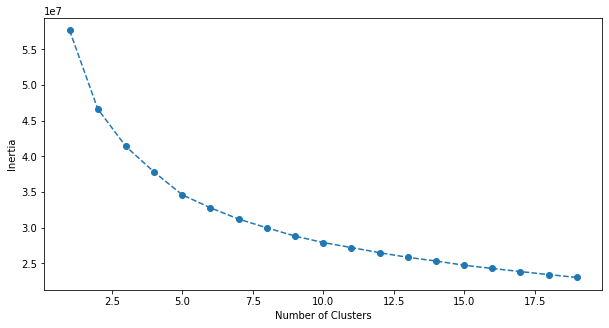

In [94]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.plot(np.arange(1, 20, 1), kmeans_score, linestyle='--', marker='o')
ax.set_ylabel('Inertia')
ax.set_xlabel('Number of Clusters')
plt.savefig('number_of_clusters.png', dpi=200, bbox_inches='tight');

We can use the 'Elbow'-method to get 'right' number of clusters. A 'Elbow' is defined as the point in the above chart where the decrease in Inertia almost flattens. In my case there isn't a clear 'Elbow' point. 10 seems to be a good choice to have enough clusters to compare against but not to much to add unnecessary complexity.

Now we can perform a KMeans-Clustering on both datasets.

In [95]:
# initiate KMeans and fit to data
k_means = KMeans(10)
model = k_means.fit(population_pca)

In [114]:
pickle.dump(model, open('kmean_model_fit.p', 'wb'))

In [96]:
# create DataFrame from the prediction for the population
pred_population = model.predict(population_pca)
azdias_clustered = pd.DataFrame(pred_population, columns = ['Cluster'])

In [97]:
# create DataFrame from the prediction for customers
# since we fitted KMeans already, we can just do the prediction
pred_customers = model.predict(customers_pca)
customers_clustered = pd.DataFrame(pred_customers, columns=['Cluster'])

##### count the number of times each cluster is represented in each population

In [98]:
azdias_vals = azdias_clustered['Cluster'].value_counts().sort_index().values

In [99]:
customers_vals = customers_clustered['Cluster'].value_counts().sort_index().values

In [100]:
result_clusters = pd.concat([pd.Series(azdias_vals), pd.Series(customers_vals)], axis=1)

In [101]:
result_clusters

,0,1
0,94687,48744
1,62303,7150
2,83050,16290
3,55310,2808
4,44737,3761
5,88699,29417
6,107206,40717
7,74841,36926
8,74010,1530
9,52445,4309


In [102]:
result_clusters.rename(columns={0:'population', 1:'customers'}, inplace=True)

In [103]:
result_clusters

,population,customers
0,94687,48744
1,62303,7150
2,83050,16290
3,55310,2808
4,44737,3761
5,88699,29417
6,107206,40717
7,74841,36926
8,74010,1530
9,52445,4309


In [104]:
# create column for proportion
result_clusters['population_pop'] = result_clusters['population']*100/result_clusters['population'].sum()
result_clusters['customers_pop'] = result_clusters['customers']*100/result_clusters['customers'].sum()

In [105]:
result_clusters

,population,customers,population_pop,customers_pop
0,94687,48744,12.842607,25.433598
1,62303,7150,8.450294,3.730720
2,83050,16290,11.264255,8.499781
3,55310,2808,7.501817,1.465156
4,44737,3761,6.067778,1.962411
5,88699,29417,12.030441,15.349175
6,107206,40717,14.540587,21.245278
7,74841,36926,10.150850,19.267213
8,74010,1530,10.038140,0.798322
9,52445,4309,7.113231,2.248346


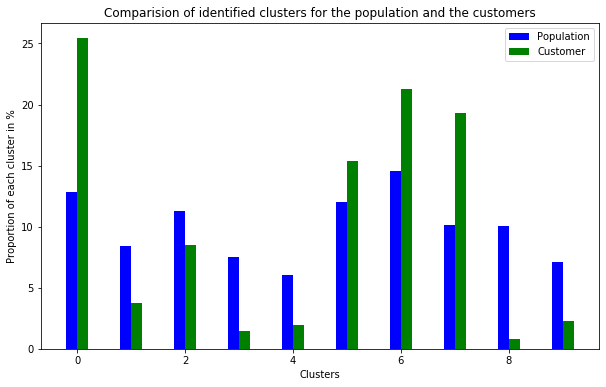

In [119]:
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(111)

ax.bar(result_clusters.index-0.1, height=result_clusters['population_pop'], width=0.2, color='b', align='center')
ax.bar(result_clusters.index+0.1, height=result_clusters['customers_pop'], width=0.2, color='g', align='center')

plt.legend(('Population', 'Customer'))
ax.set_ylabel('Proportion of each cluster in %')
ax.set_xlabel('Clusters')
plt.title('Comparision of identified clusters for the population and the customers')
plt.savefig('cluster_comp.png', dpi=200, bbox_inches='tight');

It is clear to see that almost every cluster differentiate between the customers and the general population. For customers the clusters 0, 7 and 6 are the ones that differentiate the most and for the general population its  cluster 8, 3 and 4.

I was stuck comparing the relevant clusters. The following code is from the here: https://github.com/Nokaido/Capstone_Project/blob/master/Arvato%20Project%20Workbook_own.ipynb.

I edited to function to fit my needs and added a docstring.

In [108]:
def plot_scaled_comparison(df_sample, model, cluster):
    '''
    helper function for plotting the relevant attributes for each cluster
    
    Input
        df_sample: DataFrame with the names for the attributes 
        model: fitted kmeans model 
        cluster: number of the cluster
        
    Return
        splits Dataframe to get the first and last 5 values 
    '''
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(model.cluster_centers_[cluster]))),
                               orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values',
                                                                                                 ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:5], X['feature_values'][-5:]), axis=0).plot(kind='barh');

In [109]:
def plot_cluster(df, model, cluster, title, name_of_picture):
    '''
    plots the relevant attributes for each cluster 
    
    Input
        df: DataFrame with the names for the attributes 
        model: fitted kmeans model 
        cluster: number of relevant clusters
        title: Name of the dataframe for the visualizations
        name_of_picture: name to save the file
    '''
    
    plt.figure(figsize=(10, 5))
    plot_scaled_comparison(df, model, cluster)
    plt.title(title + ' cluster ' + str(cluster))
    plt.savefig(name_of_picture, dpi=200, bbox_inches='tight')
    plt.show()

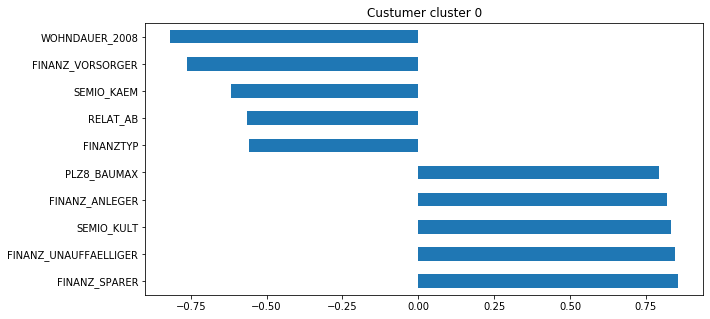

In [116]:
plot_cluster(azdias, model, 0, 'Custumer', 'cluster_0.png')

An individual part of that clusters 0:
- lives in an area with mostly family homes and low unemployment
- has a higher affinity for a fightfull attitude and is financial prepared.
- but has low financial interest, is not an investor and not good with saving money
- not really culturally minded

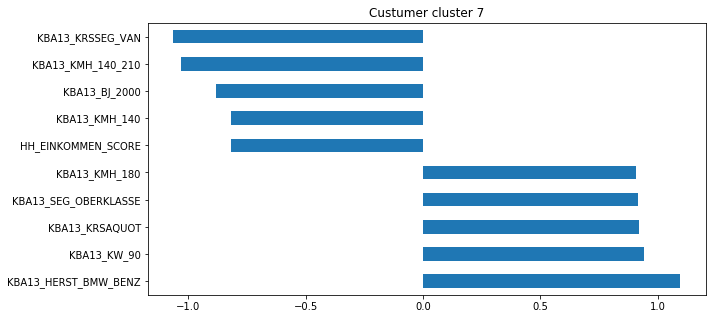

In [117]:
plot_cluster(azdias, model, 7, 'Custumer', 'cluster_7.png')

An individual part of that clusters 7 is mainly describe by its car choice:
- has a high income and a high share of upper class cars (BMW 7er etc)
- high share of cars per household
- very few cars with a max speed between 110 and 210 and were built between 2000 and 2003, so mostly new cars
- has in his area a lot less vans, compared to country average

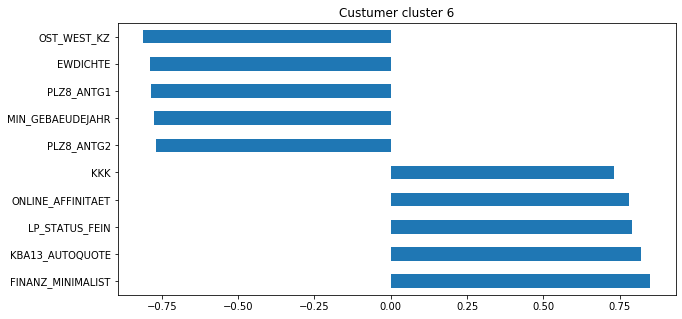

In [118]:
plot_cluster(azdias, model, 6, 'Custumer', 'cluster_6.png')

An individual part of this cluster 6:
- lives in a low density area in an old building, with only a few family houses around
- has low purchasing power but still a higher car share per household
- is more minimalistic / independent
- low financial interest
- high online affinity

#### Customers underrepresented

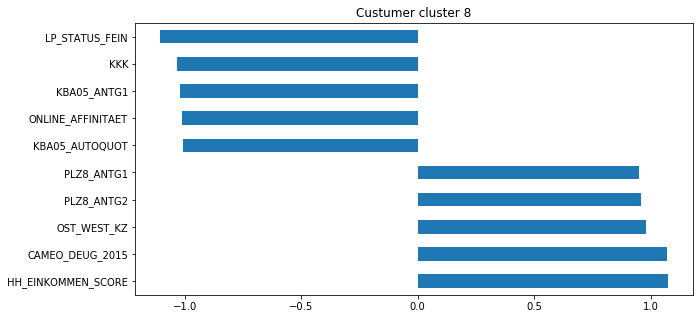

In [120]:
plot_cluster(azdias, model, 8, 'Custumer', 'cluster_8.png')

An individual part of this cluster 8:
- has high purchasing power, but has a lower income 
- is part of the lower middle-class / working-class
- has a low number of family homes in the area
- low online affinity and share of cars per household
- low car share per household

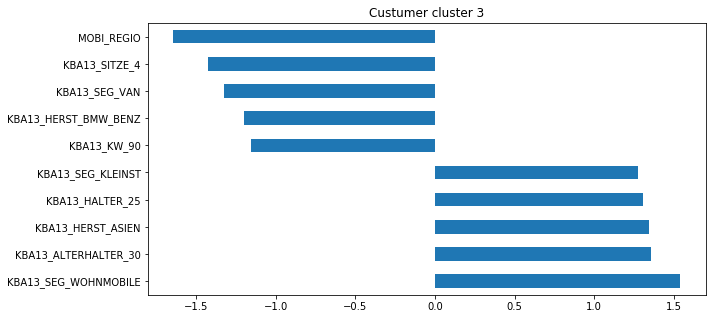

In [121]:
plot_cluster(azdias, model, 3, 'Custumer', 'cluster_3.png')

An individual part of this cluster 3:
- has high mobility, but a low number of cars with less than 5 seats
- dives mostly small cars (high number of very small cars (Ford Fiesta, Ford Ka) and low number of BMW and Mercedes)
- is mostly between 21 and 25 and drives cars from Asian manufactures 
- high share hare of car owners below 31 within the PLZ8
- and interestingly high amount of campers

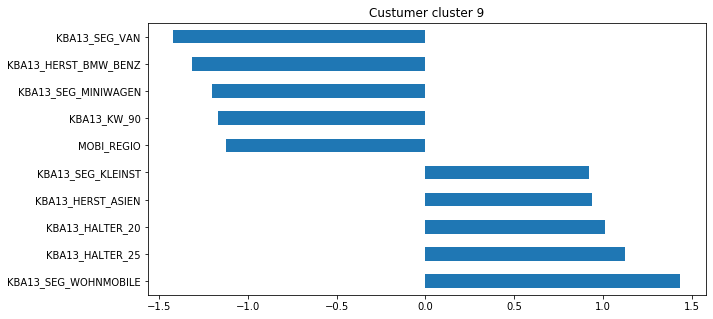

In [123]:
plot_cluster(azdias, model, 9, 'Custumer', 'cluster_9.png')

is almost the same as cluster 3

<a id='part2'></a>
## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [58]:
# read both datasets to make sure that the columns are euqal 
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [59]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [60]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


mailout_train has one column more = RESPONSE

In [70]:
# get the Response column from mailout train before applying the cleaning function, since it would remove it
y = mailout_train['RESPONSE']
y

0        0
1        0
2        0
3        0
4        0
        ..
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 42962, dtype: int64

In [62]:
# we can use the clean function for the customers dataset 
# apply the function to both datasets

mailout_train_clean = clean(mailout_train, azdias_columns, unknown_vals, dummy_features)
mailout_test_clean = clean(mailout_test, azdias_columns, unknown_vals, dummy_features)

customers DataFrame has been filtered
unkown values have been replaced with np.NaN
features have been processed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


finish
customers DataFrame has been filtered
unkown values have been replaced with np.NaN
features have been processed
finish


In [63]:
mailout_train_clean.shape

(42962, 295)

In [64]:
mailout_test_clean.shape

(42833, 295)

both dataset of the same shape lets check if the columns are the same:

In [66]:
set(mailout_train_clean) - set(mailout_test_clean)
# should be an empty set 

set()

In [68]:
len(set(mailout_train_clean) & set(mailout_test_clean))
# should be the number od columns

295

Now both DataFrames of the same shape. In the next step I will check for missing data, everytime a column gets dropped I will perform the same for the mailout_test set.

In [71]:
# add y to mailout train clean to check for missing values
mailout_train_clean = pd.concat([y, mailout_train_clean], axis=1)

In [73]:
mailout_train_clean.head()

,RESPONSE,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,0,8.0,15.0,0.0,1.0,0.0,5.0,5.0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,0,13.0,1.0,0.0,2.0,0.0,5.0,5.0,1,1,...,0,0,1,0,0,0,1,0,1,0
2,0,9.0,0.0,NaN,0.0,0.0,1.0,2.0,0,1,...,0,1,0,0,0,0,0,1,1,0
3,0,6.0,4.0,0.0,2.0,0.0,2.0,2.0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,9.0,53.0,0.0,1.0,0.0,4.0,7.0,0,0,...,0,1,0,0,0,1,0,0,1,0


#### check for missing values

In [244]:
cols_na_prop = (mailout_train_clean.shape[0] - mailout_train_clean.count(axis=0)) / mailout_train_clean.shape[0]

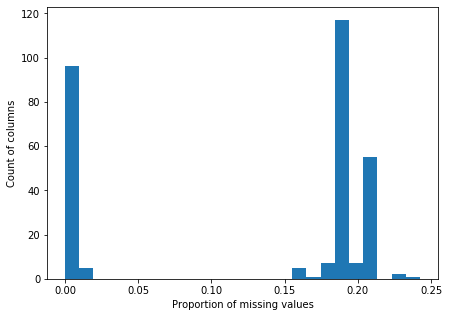

In [245]:
fig = plt.figure(figsize=(7,5))

ax = plt.subplot()
ax.hist(cols_na_prop, bins=25)
ax.set_ylabel('Count of columns')
ax.set_xlabel('Proportion of missing values')
# plt.savefig('P2_missing_values_cols.png', dpi=200, bbox_inches='tight')

There are no columns that have more than 25% of missing values. I won't drop any column.

Next, lets check the rows.

In [74]:
rows_na_prop = (mailout_train_clean.shape[1] - mailout_train_clean.count(axis=1)) / mailout_train_clean.shape[1]

Text(0.5, 0, 'Proportion of missing values')

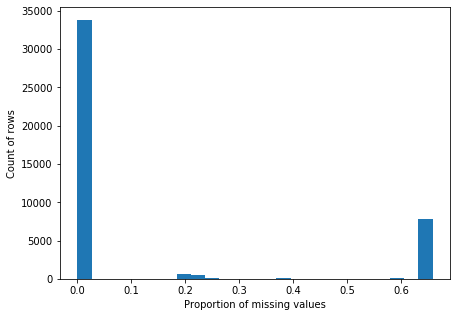

In [75]:
fig = plt.figure(figsize=(7,5))

ax = plt.subplot()
ax.hist(rows_na_prop, bins=25)
ax.set_ylabel('Count of rows')
ax.set_xlabel('Proportion of missing values')
# plt.savefig('P2_missing_values_rows.png', dpi=200, bbox_inches='tight');

There are a few rows that have more than 60% missing values. I will drop any row that has mote than 30% missing values.

In [76]:
rows_na_prop[rows_na_prop > 0.30].index

Int64Index([    8,     9,    10,    16,    18,    27,    33,    48,    62,
               69,
            ...
            42892, 42896, 42899, 42911, 42917, 42919, 42920, 42924, 42926,
            42954],
           dtype='int64', length=7962)

In [77]:
mailout_train_clean.drop(index=rows_na_prop[rows_na_prop > 0.30].index, inplace = True)

Since I only dropped rows I don't need do anything with mailout_test

### Split Data

In [82]:
# now we can split the train data in x and y
x = mailout_train_clean.iloc[:, 1:]
y = mailout_train_clean['RESPONSE']

In [84]:
x.shape, y.shape

((35000, 295), (35000,))

### Impute missing values and scale features

In [85]:
# define imputer and scaler
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [86]:
# apply imputer and scaler
x_imp = pd.DataFrame(imputer.fit_transform(x))
x_sc = pd.DataFrame(scaler.fit_transform(x_imp), columns = x.columns)

In [87]:
x_sc

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,...,KBA05_MODTEMP_6.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-0.378933,0.555185,-0.131472,-0.751147,-0.091728,0.337010,0.016016,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,-0.465526,1.279815,-1.012594,1.036969
1,0.443343,-0.378700,-0.131472,-0.016211,-0.091728,0.337010,0.016016,1.786421,1.156790,-2.415979,...,-0.090286,-4.673965,6.979678,-0.119159,-0.455362,-0.591473,2.148109,-0.781363,0.987563,-0.964349
2,-0.214478,-0.445406,-0.131472,-1.486084,-0.091728,-1.486004,-1.225990,-0.246177,1.156790,-1.273363,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,-0.465526,1.279815,0.987563,-0.964349
3,-0.707843,-0.178582,-0.131472,-0.016211,-0.091728,-1.030250,-1.225990,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,1.690695,-0.465526,-0.781363,-1.012594,1.036969
4,-0.214478,3.090013,-0.131472,-0.751147,-0.091728,-0.118743,0.844020,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,1.690695,-0.465526,-0.781363,0.987563,-0.964349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,-1.694573,-0.378700,-0.131472,-0.016211,-0.091728,-1.030250,-0.811988,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,-0.465526,1.279815,0.987563,-0.964349
34996,-1.694573,-0.378700,-0.131472,-0.016211,-0.091728,0.792764,0.430018,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,2.148109,-0.781363,-1.012594,1.036969
34997,0.936708,-0.311994,-0.131472,0.718726,-0.091728,0.792764,-0.397986,-0.246177,-0.306390,0.440560,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,-0.465526,1.279815,0.987563,-0.964349
34998,1.265618,-0.245288,-0.131472,0.718726,-0.091728,0.792764,1.258022,3.819018,4.083149,-2.415979,...,-0.090286,0.213951,-0.143273,-0.119159,-0.455362,-0.591473,-0.465526,1.279815,0.987563,-0.964349


### Check for highly correlated features

In [88]:
# Create correlation matrix
corr_matrix = x_sc.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [89]:
to_drop

['KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_STATUS_GROB',
 'ANREDE_KZ_2.0',
 'KBA05_MODTEMP_5.0',
 'VERS_TYP_2.0']

In [93]:
x_sc.drop(columns=to_drop, inplace=True)

In [90]:
# the same columns need to be droped from the mailout_test_clean DataFrame
mailout_test_clean.drop(columns=to_drop, inplace=True)

In [94]:
x_sc.shape, mailout_test_clean.shape

((35000, 289), (42833, 289))

In [97]:
# make sure
len(set(x_sc) & set(mailout_test_clean))

289

### Inspect RESPONSE variable

In [297]:
y.value_counts()

0    34565
1      435
Name: RESPONSE, dtype: int64

Response is highly imbalanced. According to this <a href='https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7'>article</a> I need to be aware of the following things:
- stratify your data for training and validation
- choose the right evaluation metric: ROC curve 
- use Gradient Boosting

Advanced steps to deal with imbalanced data:
- Resampling to get more balanced data
- Class weighted / cost sensitive learning

### Create Model

In [259]:
# define basic classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

In [260]:
scv = StratifiedKFold(n_splits=5)

In [261]:
def ml_pipeline(classifiers, X, y):
    '''
    Input
        model: dict with classifiers
        X: features
        y: label
        
    Return
        confusion matrix and roc_auc score for each model
    '''

    for name, model in classifiers.items():
        score = cross_val_score(model, X, y, scoring='roc_auc', cv=scv).mean()
        print(name, ':')
        print(score)
        print('-'*55)

In [262]:
ml_pipeline(classifiers, x_sc, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

LogisticRegression :
0.5388771114225904
-------------------------------------------------------
DecisionTreeClassifier :
0.5065447241661969
-------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

RandomForestClassifier :
0.5025457616916987
-------------------------------------------------------
AdaBoostClassifier :
0.5262902976401282
-------------------------------------------------------
GradientBoostingClassifier :
0.5461740415775044
-------------------------------------------------------


The GradientBoostingClassifier has the highest score. In the next step I will try to enhance the classifier with hyperparameter tuning:

In [215]:
# define parameters
hyper_params = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

In [216]:
# reduced the number of splits to reduce processing time
scv = StratifiedKFold(n_splits=2)

In [217]:
find_model = GridSearchCV(estimator = GradientBoostingClassifier(),
                          param_grid = hyper_params,
                          n_jobs = -2,
                          scoring = 'roc_auc',
                          verbose = 2, 
                          cv = scv)

In [218]:
find_model.fit(x_sc, y)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed: 18.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n

In [219]:
print(find_model.best_score_)
print(find_model.best_estimator_)

0.5940557598698858
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


I managed to increase the score from 0.546 to 0.594 with GridSearch

<a id='part3'></a>
## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [99]:
mailout_test_clean.shape

(42833, 289)

In [100]:
# save the id_number to upload the data to Kaggle
id_number = mailout_test['LNR']
id_number

0         1754
1         1770
2         1465
3         1470
4         1478
         ...  
42828    67615
42829    67938
42830    67942
42831    67949
42832    68898
Name: LNR, Length: 42833, dtype: int64

### Impute and scale values

In [103]:
test_x_imp = pd.DataFrame(imputer.fit_transform(mailout_test_clean))
test_x_sc = pd.DataFrame(scaler.fit_transform(test_x_imp), columns = mailout_test_clean.columns)

In [107]:
# both datasets have the same columns
len(set(test_x_sc) & set(x_sc))

289

### Model

In [108]:
# define optimal model
best_params = {
    'learning_rate': [0.1],
    'max_depth': [5],
    'n_estimators': [200]
}

In [110]:
# define StratifiedKFold
scv = StratifiedKFold(n_splits=3)

In [111]:
# initiate final model
final_model = GridSearchCV(estimator = GradientBoostingClassifier(), 
                           param_grid = best_params, 
                           scoring = 'roc_auc', 
                           cv = scv,
                           n_jobs= -2)

In [112]:
# fit model with the data from part 2 (mailout_train) to make predictions with the data from part 3 (mailout_test)
final_model.fit(x_sc, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n

In [113]:
# used predict_proba, to get the estimates for each label and therefore the probabilioty 
# if an individual will become a customer
test_preds = final_model.predict_proba(test_x_sc)

In [114]:
# first column is the probability for zero
# scond column is the probability for one
test_preds

array([[9.84076349e-01, 1.59236506e-02],
       [9.99153580e-01, 8.46420060e-04],
       [9.97309894e-01, 2.69010607e-03],
       ...,
       [9.99384771e-01, 6.15228744e-04],
       [9.66435223e-01, 3.35647773e-02],
       [9.98065975e-01, 1.93402538e-03]])

In [115]:
test_preds.shape

(42833, 2)

In [116]:
kaggle = pd.DataFrame({'LNR':id_number, 'RESPONSE':test_preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.015924
1,1770,0.000846
2,1465,0.002690
3,1470,0.001821
4,1478,0.003152


Score on Kaggle:  0.53612

## Conclusions

To recap, the first goal of this project was to perform an unsupervised learning algorithm to uncover differences between customers and the general population. The second goal was to perform a supervised learning algorithm to predict if an individual became a customer and the last goal was to use this trained model to predict on unseen data and upload the results to Kaggle.

The first part (unsupervised learning) was very challenging for me. It was the first time that I worked with a huge datafile (> 1GB). So, at first it was quite frustrating working on the provided workspace, since some operations took a while. I decided to download the data to work on it on my local machine.
Besides the huge dataset, the data cleaning was also very challenging, and I used quite frequently methods that I didn't used before, so it was on the other side quite rewarding to implement a new method and get the expected result.

Again, it became clear that the most work a data scientist has is the cleaning step.

### Limitations

My final score is compared to others on Kaggle relatively low. I looked at a few other notebooks on github to get an idea why. It seems that my approach, to only keep the columns that are in the dataset and in the excel file is quite unique. To recap, I dropped 94 columns that weren't in both files, with the idea that I can only use attributes for which I have the description. After the analysis I inspected the excel file and noticed that some Attributes are just spelled differently between the excel file and the dataset. So, all in all I probably dropped some columns that meight would increase my score.

Another thing that I noticed is that I dropped rows in the supervised learning part. Which is debatable because the variable of interest is to highly imbalanced and one can argue that it would be better to keep rows with missing values, so that there is a higher chance for the imbalanced value to appear.

#### All in all, here are some things that could be checked to enhance the final score:
- get a better understanding of the attributes and check if you can use more attributes without dropping them (keep attributes with more than 10 items)
- don't drop attributes because they aren't in the Excel file
- use more advanced methods to impute missing values (imputations based on distributions ore even use a learning algorithm to predict the missing value)
- use more advanced techniques to deal with imbalanced data (resampling to get more balanced data, weighted classes / cost sensitive learning).